In [1055]:
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch import FloatTensor as tensor
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import pandas as pd

In [1056]:
device = torch.device("cpu" if torch.cuda.is_available() else "cpu")

In [1057]:
device

device(type='cpu')

In [1058]:
datasets = pd.read_csv('./datasets/__train.csv')

In [1059]:
datasets_survived=datasets[datasets['Survived']==1]
datasets_die=datasets[datasets['Survived']==0]

In [1060]:
datasets_survived.shape, datasets_die.shape

((263, 11), (512, 11))

In [1061]:
datasets_die=datasets_die[:400]

In [1062]:
datasets=pd.concat([datasets_survived, datasets_die])
datasets=datasets.sample(frac=1).reset_index(drop=True)

In [1063]:
datasets.head(10)

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_C,Embarked_Q,Embarked_S,IsAgeNull
0,0,1,1.175,0.0,0.000000,1.184615,1,0,0,1,0
1,0,3,0.025,1.6,0.333333,1.221154,1,0,0,1,0
2,1,3,0.675,0.0,0.333333,0.383846,0,0,0,1,0
3,0,3,0.425,0.4,0.333333,0.222437,1,1,0,0,0
4,1,2,0.600,0.0,0.666667,0.446154,0,0,0,1,0
5,0,3,0.500,0.0,0.000000,0.123462,1,1,0,0,0
6,0,3,0.000,0.4,0.000000,0.476923,1,0,1,0,1
7,0,2,0.575,0.0,0.000000,0.323077,1,0,0,1,0
8,0,3,0.700,0.4,0.333333,0.443077,0,0,0,1,0
9,1,3,0.075,0.4,0.333333,0.489231,1,0,0,1,0


In [1064]:
y_data = datasets[['Survived']]
x_data = datasets.drop('Survived', axis=1)

In [1065]:
x_data, y_data = tensor(x_data.values).to(device), tensor(y_data.values).to(device)

In [1066]:
x_data.shape, y_data.shape

(torch.Size([663, 10]), torch.Size([663, 1]))

In [1067]:
train=int(0.8*x_data.shape[0])
test=x_data.shape[0]-train
sample_size_train, sample_size_test = train, test
batch_size = 10
epoches = 500

In [1068]:
x_train, x_test=x_data[:train], x_data[train:]
y_train, y_test=y_data[:train], y_data[train:]

In [1069]:
class learning(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer = nn.Sequential(
            nn.Linear(10, 8),
            nn.LeakyReLU(),
            nn.Linear(8, 4),
            nn.LeakyReLU(),
            nn.Linear(4, 1),
            nn.Sigmoid()
        )
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.layer(x)
        return x

In [1070]:
model = learning().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

datasets_train = TensorDataset(x_train, y_train)
dataloader_train = DataLoader(datasets_train, batch_size=batch_size, shuffle=True, drop_last=True)

datasets_test = TensorDataset(x_test, y_test)
dataloader_test = DataLoader(datasets_test, batch_size=1, shuffle=True, drop_last=True)

In [1071]:
x_train.device

device(type='cpu')

In [1072]:
history_train, history_test, history_accuracy = [], [], []

In [1073]:
for epoch in range(100):
    cost_train, cost_test, acc = 0, 0, 0
    
    for batch_ind, sample in enumerate(dataloader_train):
        x, y = sample
        prediction = model(x)
        cost = F.binary_cross_entropy(prediction, y)
        optimizer.zero_grad()
        cost.backward()
        optimizer.step()
        cost_train += cost.item()
        
    for batch_ind, sample in enumerate(dataloader_test):
        x, y = sample
        prediction = model(x)
        cost = F.binary_cross_entropy(prediction, y)
        cost_test += cost.item()
        
        acc+=sum(list(map(lambda x:1 if float(x)<0.5 else 0, list(y-prediction))))
    
    cost_train, cost_test=cost_train / int(sample_size_train / batch_size), cost_test / sample_size_test
    acc=acc/sample_size_test
    
    if (epoch + 1) % 10 == 0:
        print("epoch {} : {:.5f}, {:.5f}, {}".format(epoch + 1, cost_train, cost_test, int(acc*100)))

    history_train.append(cost_train)
    history_test.append(cost_test)
    history_accuracy.append(acc)

epoch 10 : 0.62309, 0.59143, 78
epoch 20 : 0.49762, 0.48241, 87
epoch 30 : 0.48214, 0.47883, 87
epoch 40 : 0.47574, 0.45889, 87
epoch 50 : 0.46647, 0.45373, 87
epoch 60 : 0.46305, 0.44535, 86
epoch 70 : 0.45835, 0.43719, 86
epoch 80 : 0.45628, 0.43054, 85
epoch 90 : 0.45034, 0.43015, 87
epoch 100 : 0.44695, 0.42531, 87


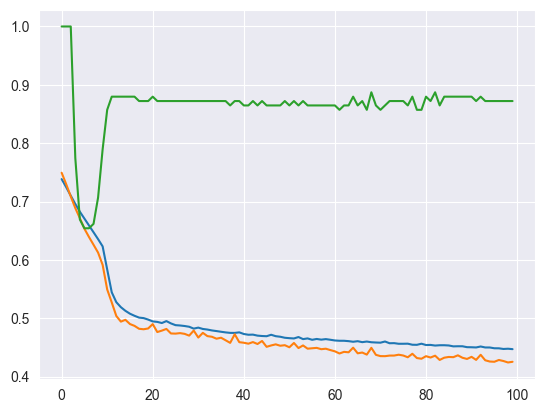

In [1074]:
plt.plot(history_train)
plt.plot(history_test)
plt.plot(history_accuracy)

In [1075]:
history_accuracy[-1]*100

87.21804511278195

In [1076]:
torch.save(model.state_dict(), 'model.pt')

In [1077]:
sample_size_test

133